In [1]:
from   torchvision import transforms, datasets
import torchvision

import torch.nn.functional as F
from   torch import nn, optim
import torch

import matplotlib.pyplot as plt
from   time import time
import numpy as np

In [2]:
# Baixando as imagens e convertendo para tensor
# Definindo a transformação de imagem para o modelo (Tensor)
transform = transforms.ToTensor()

# =====================================================================
# =====================================================================
trainset = datasets.MNIST( # Carregando o conjunto de dados MNIST
    './MNIST_data/',       # Parte do treino do dataset
    download=True,
    train=True,
    transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset,       # Criando o DataLoader para o conjunto de treino
    batch_size=64,  # Cria um buffer para pegar os dados por partes
    shuffle=True)


# =====================================================================
# =====================================================================
valset = datasets.MNIST( # Carrega parte da validação do dataset
    './MNIST_data/',
    download=True,
    train=False,
    transform=transform)

valloader = torch.utils.data.DataLoader(
    valset,    # Cria um buffer para pegar os dados por partes
    batch_size=64,
    shuffle=False)

# =====================================================================
# =====================================================================


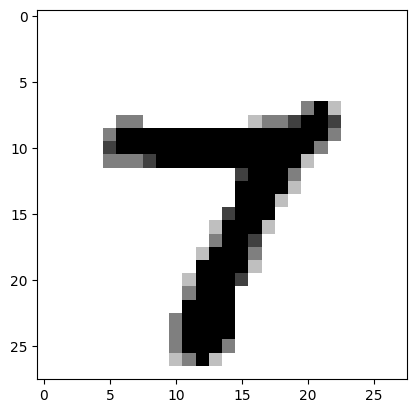

In [3]:
# Carregando uma imagem do treinamento

dataiter = iter(trainloader)
imagens, labels = next(dataiter)

plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')  # Mostra a imagem

In [4]:
print(imagens[0].shape) # Para verificar as dimensões do tensor de cada imagem
print(labels[0].shape)  # Para verificar as dimensões do label de cada imagem

torch.Size([1, 28, 28])
torch.Size([])


In [5]:
# Copiar as camadas da rede InceptionV3
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()  # Inicializa a classe pai
        self.linear1 = nn. Linear(28*28, 128) # Camada de entrada, 784 neuronios que se ligan a 128
        self.linear2 = nn. Linear(128, 64) # Camada interna 1, 128 neuronios que se ligan a 64
        self.linear3 = nn.Linear(64, 10) # Camada interna 2, 64 neuronios que se ligam a 10
# para a camada de saida nao e necessario definir nada pois so precisamos pegar o output da camada interna 2

    def forward(self, X):
        X = F.relu(self.linear1(X)) # Funcão de ativacão da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X)) # Funcao de ativacao da camada interna 1 para a camada interna 2
        X = self.linear3(X) # Função de ativação da camada interna 2 para a camada de saida, nesse caso f(x) = x
        return F.log_softmax(X, dim=1) # Dados utilizados para calcular a perda

In [6]:
# Implementar a parte de otimização da rede
# onde é a primeira vista a parte de atualização dos pesos
# para isso devemos utilizar um "otimizador"

def treinar_modelo(modelo, trainloader, device):
    # define a política de atualização dos pesos e da bias
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)
    inicio = time() # Time para saber quanto tempo levou o treinamento 

    criterio = nn.NLLLoss() # Define o critério para calcular a perda
    EPOCHS = 30 # Define o número de épocas para o treinamento
    modelo.train() # Ativa o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0 # inicia a contagem da perda acumulada

        for imagens, etiquetas in trainloader:
            imagens = imagens.view(imagens.shape[0], -1) # Redimensiona as imagens para "Vetores" de 28*28 casas para ficarem compatíveis com a entrada da rede
            otimizador.zero_grad() # Zera os gradientes do otimizador por conta do ciclo anterior

            output = modelo(imagens.to(device)) # Passa as imagens pelo modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) # Calcula a perda da época em questão
            perda_instantanea.backward() # Backpropagation à partir da perda

            otimizador.step() # Atualiza os pesos do modelo e as bias
            perda_acumulada += perda_instantanea.item() # Atualização da perda acumulada

        else:
            print(f"Epoch {epoch+1}/{EPOCHS}, Perda: {perda_acumulada/len(trainloader)}", end='\n\n')
    print(f"Tempo total de treinamento em minutos: {(time() - inicio) / 60} minutos")

In [7]:
# Implementando o modelo de validação
# Vai nos mostrar a precisão do modelo (Acurácia)
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0

    for imagens,etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784)

            # Desativar o autograd para acelerar a validacao. Grafos computacionais dinâmicos tem um custo alto de processamento
            with torch.no_grad():
                logps = modelo(img.to(device)) # Output do modelo em escala logaritmica

            ps = torch.exp(logps) # Converte output para escala normal(lembrando que é um tensor)
            probab = list(ps.cpu().numpy()[0])
            etiqueta_pred = probab.index(max(probab)) # Converte o tensor em um número, no caso, o número que o modelo previu como correto
            etiqueta_certa = etiquetas.numpy()[i]
            
            if(etiqueta_certa == etiqueta_pred): # Compara a previsão com o valor correto
                conta_corretas += 1
            conta_todas += 1

    print("Total de imagens testadas =", conta_todas)
    print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))


In [8]:
# Verificando se temos uma GPU disponível para treinamento
modelo = Modelo()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
# Chamando o modelo para executar nosso treinamento e validação
treinar_modelo(modelo, trainloader, device)
validacao(modelo, valloader, device)

Epoch 1/30, Perda: 1.1310881617099746

Epoch 2/30, Perda: 0.37968996693012813

Epoch 3/30, Perda: 0.3133257011106528

Epoch 4/30, Perda: 0.2762480244072261

Epoch 5/30, Perda: 0.24591628469224933

Epoch 6/30, Perda: 0.219185466419405

Epoch 7/30, Perda: 0.19676710673963338

Epoch 8/30, Perda: 0.17802948775147198

Epoch 9/30, Perda: 0.16179067264996103

Epoch 10/30, Perda: 0.14814073337055345

Epoch 11/30, Perda: 0.13649728345368972

Epoch 12/30, Perda: 0.12649967342511867

Epoch 13/30, Perda: 0.1178989146125199

Epoch 14/30, Perda: 0.11046333207901735

Epoch 15/30, Perda: 0.1030012609939506

Epoch 16/30, Perda: 0.09664813100274947

Epoch 17/30, Perda: 0.0908314059399116

Epoch 18/30, Perda: 0.08577188144652431

Epoch 19/30, Perda: 0.08136602376909383

Epoch 20/30, Perda: 0.0767959913632064

Epoch 21/30, Perda: 0.07280345661029505

Epoch 22/30, Perda: 0.06895138304541583

Epoch 23/30, Perda: 0.06577232576060746

Epoch 24/30, Perda: 0.06231128166951954

Epoch 25/30, Perda: 0.059644528374

: 